# Pytorch scalar non-linear regression 2D 

* Author: J. Hickman
* scalar linear regression 

#### Import

In [150]:
import torch
import numpy as np
import matplotlib.pyplot as plt

#### Generate data

In [151]:
# GENERATE DATA TO FIT
x=np.random.uniform(-10,10,(100,2))
print(x.shape)
pe=np.random.uniform(-3,3,(6,))
y = pe[0]*x[:,0]**2 + pe[1]*x[:,0]*x[:,1] +pe[2]*x[:,1]**2 + pe[3]*x[:,0] + pe[4]*x[:,1] + pe[5] 
y += 0.04*np.random.uniform(np.min(y),np.max(y),size=len(x))
print("EXACT PARAMETERS:",pe)

(100, 2)
EXACT PARAMETERS: [ 0.17170808 -2.78326765  0.83391259 -1.00589308 -0.41537011 -1.92895682]


#### Neural network model

nn.Module is the base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in a tree structure. You can assign the submodules as regular attributes:

An __init__() call to the parent class must be made before assignment on the child.

https://pytorch.org/docs/stable/generated/torch.nn.Module.html



In [152]:
# GET CPU OR GPU DEVICE FOR TRAINING.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"USING {device} DEVICE")

input_dimension=x.shape[1]

# # Define model
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        #__init__() call to the parent class
        super(NeuralNetwork, self).__init__()
        #define linear model
        self.linear_model = torch.nn.Sequential(
            torch.nn.Linear(input_dimension, 6),
            torch.nn.Sigmoid(),
            torch.nn.Linear(6, 6),
            torch.nn.Sigmoid(),
            torch.nn.Linear(6, 1),
        )

    #FORWARD PASS (EVALUATION OF MODEL)
    def forward(self, x):
        out = self.linear_model(x)
        return out

#INITIALIZE MODEL 
model = NeuralNetwork().to(device)
print(model)


USING cpu DEVICE
NeuralNetwork(
  (linear_model): Sequential(
    (0): Linear(in_features=2, out_features=6, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=6, out_features=6, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=6, out_features=1, bias=True)
  )
)


In [153]:
#CHECK PARAMETERS (NOTICE HOW THEY WERE AUTOMATICALLY RANDOMIZED)
for param in model.parameters():
    print(param)
    print(param.shape)
    print(param.requires_grad)

Parameter containing:
tensor([[ 0.0644,  0.5760],
        [ 0.6723, -0.2444],
        [ 0.2932, -0.1247],
        [ 0.5503,  0.4839],
        [ 0.2175, -0.2975],
        [ 0.4161,  0.2772]], requires_grad=True)
torch.Size([6, 2])
True
Parameter containing:
tensor([-0.4192,  0.0557,  0.1179, -0.2082,  0.0551, -0.4207],
       requires_grad=True)
torch.Size([6])
True
Parameter containing:
tensor([[-0.4074, -0.0188,  0.2554,  0.2139, -0.1570, -0.0080],
        [-0.2975, -0.2533, -0.2688, -0.0343, -0.2617, -0.1198],
        [-0.0891,  0.1734, -0.0413,  0.4006, -0.1801, -0.0991],
        [-0.0422, -0.0448, -0.2631, -0.3689, -0.2932, -0.2444],
        [ 0.0156, -0.1349,  0.2693, -0.3693, -0.0007, -0.1173],
        [-0.3829, -0.4012,  0.4012, -0.1156, -0.1965, -0.3406]],
       requires_grad=True)
torch.Size([6, 6])
True
Parameter containing:
tensor([-0.2867, -0.3913,  0.1921,  0.1909,  0.1423, -0.0731],
       requires_grad=True)
torch.Size([6])
True
Parameter containing:
tensor([[-0.3847, -

In [154]:
# CONVERT TO TORCH TENSOR AND EVALUATE MODEL AS A TEST
x=torch.tensor(x).view(x.shape[0],x.shape[1])
y=torch.tensor(y).view(x.shape[0],1)

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=0)

print("X-VALIDATION:",x_val.shape,x_val.dtype)
print("Y-VALIDATION:",y_val.shape,y_val.dtype)
print("X-TRAIN:",x_train.shape,x_train.dtype)
print("Y-TRAIN:",y_train.shape,y_train.dtype)
y_pred = model(x_train.float())
print("PREDICTION:",y_pred.shape,y_pred.dtype)


X-VALIDATION: torch.Size([20, 2]) torch.float64
Y-VALIDATION: torch.Size([20, 1]) torch.float64
X-TRAIN: torch.Size([80, 2]) torch.float64
Y-TRAIN: torch.Size([80, 1]) torch.float64
PREDICTION: torch.Size([80, 1]) torch.float32


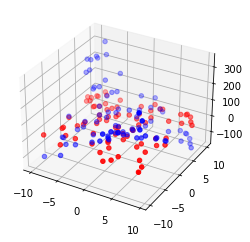

In [155]:
# PLOT THE FIGURE
# ax.scatter(x_val[:,0], x_val[:,1], y_val, c = 'r', marker='o')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train[:,0], x_train[:,1], y_train, c = 'b', marker='o')
ax.scatter(x_train[:,0], x_train[:,1], y_pred.detach().numpy(), c = 'r', marker='o')
plt.show()


#### Initialize 

In [156]:

#INITIALIZE ARRAYS TO SAVE HISTORY
epoch_array=[]
val_loss_history=[]
train_loss_history=[]

#INITIALIZE LOSS FUNCTION AND OPTIMIZER
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-2)


#### Utility functions 

In [157]:
i_print=True

def train(x_train,y_train, model, loss_fn, optimizer):
    #TELL MODEL IT SHOULD BE TRAINING
    model.train()

    #BATCH IMPLEMENTATION 
    X, y = x_train.to(device).float(), y_train.to(device).float()

    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # if t % 5 == 0:
    loss = loss.item() 
    train_loss_history.append(loss)

    if(i_print):
        print(f"loss: {loss:>7f}")

In [158]:
def validate(x_val,y_val, model, loss_fn):
    #TELL MODEL IT SHOULD BE EVALUATING
    model.eval()
    X, y = x_val.to(device).float(), y_val.to(device).float()
    pred = model(X)
    val_loss = loss_fn(pred, y).item()
    val_loss_history.append(val_loss)
    if(i_print):
        print(f"Test Error: {val_loss:>8f}")

    #FOR CLASSIFICATION 
    # correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # correct /= y.shape[0]
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

#### Training loop

In [159]:
epochs = 6000

for t in range(epochs):
    epoch_array.append(t)
    if t%500==0:
        i_print=True
        print(f"-------------------------------\nEpoch {t}")

    else: 
        i_print=False

    train(x_train,y_train, model, loss_fn, optimizer)
    validate(x_val,y_val, model, loss_fn)
print("Done!")

-------------------------------
Epoch 0
loss: 13542.830078
Test Error: 9475.795898
-------------------------------
Epoch 500
loss: 9351.941406
Test Error: 6068.122070
-------------------------------
Epoch 1000
loss: 7072.426758
Test Error: 4223.742676
-------------------------------
Epoch 1500
loss: 5529.737305
Test Error: 3237.006348
-------------------------------
Epoch 2000
loss: 4395.712402
Test Error: 2506.009277
-------------------------------
Epoch 2500
loss: 3499.541748
Test Error: 2023.826172
-------------------------------
Epoch 3000
loss: 2813.263672
Test Error: 1713.981445
-------------------------------
Epoch 3500
loss: 2287.297363
Test Error: 1470.239990
-------------------------------
Epoch 4000
loss: 1903.403076
Test Error: 1350.161255
-------------------------------
Epoch 4500
loss: 1633.581299
Test Error: 1263.808105
-------------------------------
Epoch 5000
loss: 1444.740601
Test Error: 1216.263062
-------------------------------
Epoch 5500
loss: 1308.573853
Test Er

#### Plot results

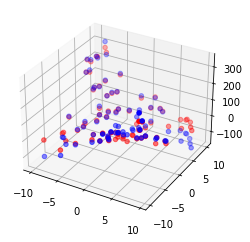

In [160]:
# PLOT THE FIGURE
y_pred = model(x_train.float())

# PLOT THE FIGURE
# ax.scatter(x_val[:,0], x_val[:,1], y_val, c = 'r', marker='o')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train[:,0], x_train[:,1], y_train, c = 'b', marker='o')
ax.scatter(x_train[:,0], x_train[:,1], y_pred.detach().numpy(), c = 'r', marker='o')
plt.show()

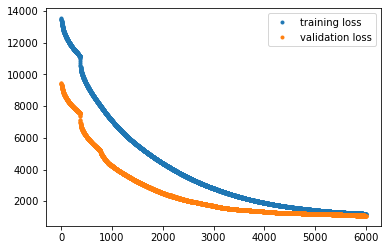

In [161]:
# PLOT THE FIGURE
y_pred = model(x_train.float())

fig, ax = plt.subplots()
ax.plot(epoch_array, train_loss_history, '.', label='training loss')
ax.plot(epoch_array, val_loss_history, '.', label='validation loss')
ax.legend()
plt.show()